# CNN模型的迁移学习

#1、很多时候我们需要训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，
而是利用预训练的模型来加速训练的过程。我们经常使用在ImageNet上的预训练模型。
#2、这是一种transfer learning的方法。我们常用一下两种方法做迁移学习。
    #2-1、fine tuning：从一个预训练模型开始，我们改变一些模型的架构，然后继续训练整个模型的参数。
    （如果我们有的训练数据比较多，可以做fine tuning）
    #2-2、feature extraction：我们不再改变预训练模型的参数，而是只更新我们改变过的部分模型参数。
     我们之所以叫他feature extraction是因为我们把预训练的CNN模型当做一个特征提取模型，
     利用提取出来的特征来完成我们的训练任务。

#3、以下是构建和训练迁移学习模型的基本步骤：
    #3-1、初始化预训练模型
    #3-2、把最后一层的输出层改变成我们想要的类别总数
    #3-3、定义一个optimizer来更新参数
    #3-4、模型训练

In [28]:
import numpy as np
import torch 
import torchvision
from torchvision import datasets, transforms, models

import torch.nn as nn
import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.4.1.post2


数据
------

我们会使用*hymenoptera_data*数据集，[下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

这个数据集包括两类图片, **bees** 和 **ants**, 这些数据都被处理成了可以使用`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`来读取的格式。我们只需要把``data_dir``设置成数据的根目录，然后把``model_name``设置成我们想要使用的与训练模型：
::
   [resnet, alexnet, vgg, squeezenet, densenet, inception]

其他的参数有：
- ``num_classes``表示数据集分类的类别数
- ``batch_size``
- ``num_epochs``
- ``feature_extract``表示我们训练的时候使用fine tuning还是feature extraction方法。如果``feature_extract = False``，整个模型都会被同时更新。如果``feature_extract = True``，只有模型的最后一层被更新。

查看数据，只是查看作用
---------

In [29]:
data_dir = "/Users/zhenwuzhou/.keras/datasets/hymenoptera_data"

model_name = 'resnet' # 用resnet来做迁移学习

num_classes = 2 # 2分类问题

batch_size = 32

num_epochs = 15

feature_extract = True 

input_size = 224 # 图片的尺寸224*224;这个是ImageFolder中的transforms会把图片处理后的尺寸

读取数据
---------
现在我们知道了模型输入的size,我们可以把数据处理成相应的格式

In [30]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir,"train"),
                                transforms.Compose([
        transforms.RandomResizedCrop(input_size), # 把图片统一处理成224*224的图片
        transforms.RandomHorizontalFlip(), # 随机裁剪
        transforms.ToTensor(),
]))
loader = torch.utils.data.DataLoader(all_imgs,batch_size=batch_size,shuffle=True,
                                    num_workers=4)
#训练数据分batch，变成tensor迭代器

In [32]:
img = next(iter(loader))[0]
print(img.shape)
img

torch.Size([32, 3, 224, 224])


tensor([[[[0.1804, 0.1804, 0.1804,  ..., 0.2627, 0.2627, 0.2667],
          [0.1804, 0.1804, 0.1804,  ..., 0.2667, 0.2667, 0.2706],
          [0.1843, 0.1843, 0.1843,  ..., 0.2706, 0.2706, 0.2745],
          ...,
          [0.5294, 0.5529, 0.5922,  ..., 0.3765, 0.3765, 0.3725],
          [0.6980, 0.7176, 0.7176,  ..., 0.3569, 0.3529, 0.3451],
          [0.7922, 0.8078, 0.7843,  ..., 0.3451, 0.3412, 0.3333]],

         [[0.5608, 0.5608, 0.5608,  ..., 0.6000, 0.6000, 0.6039],
          [0.5608, 0.5608, 0.5608,  ..., 0.6039, 0.6039, 0.6078],
          [0.5647, 0.5647, 0.5647,  ..., 0.6078, 0.6078, 0.6118],
          ...,
          [0.6392, 0.6706, 0.7020,  ..., 0.5725, 0.5569, 0.5412],
          [0.7843, 0.8078, 0.8039,  ..., 0.5451, 0.5255, 0.5098],
          [0.8627, 0.8824, 0.8588,  ..., 0.5294, 0.5098, 0.4902]],

         [[0.5843, 0.5843, 0.5843,  ..., 0.5961, 0.5961, 0.6000],
          [0.5843, 0.5843, 0.5843,  ..., 0.5961, 0.5961, 0.6000],
          [0.5882, 0.5882, 0.5882,  ..., 0

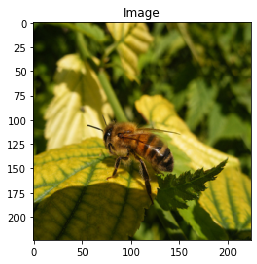

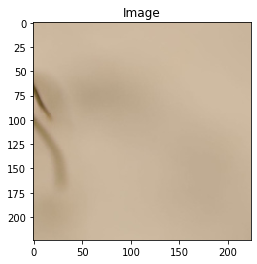

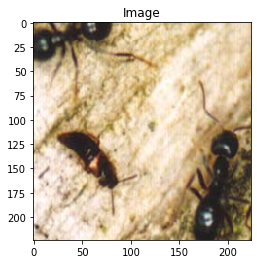

In [5]:
unloader = transforms.ToPILImage() # reconvert into PIL image
#transforms：torchvision的子模块，常用的图像操作
#.ToPILImage() 把tensor或数组转换成图像
#详细转换过程可以看这个：https://blog.csdn.net/qq_37385726/article/details/81811466

plt.ion()

def imshow(tensor,title=None):
    image = tensor.cpu().clone() # we clone the tensor to not do changes on it
    image = image.squeeze(0) # remove the fake batch dimension 
    
    image = unloader(image)#tensor转换成图像
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    #可以去掉看看，只是延迟显示作用，在绘制多张图片的时候的中间的时间间隔

plt.figure()
imshow(img[31],title='Image')
imshow(img[1],title='Image')
imshow(img[2],title='Image')

把训练集和验证集分batch转换成迭代器
---------

In [46]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size), # 这里是Resize
        transforms.CenterCrop(input_size), # 用centerCorp的方式来缩放图片到指定的input_size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 创建训练和验证数据集
# Create training and validation datasets
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                  data_transforms[x]) for x in ["train","val"]}

# Create training and validation dataloaders
#把迭代器存放到字典里作为value，key是train和val，后面调用key即可。
dataloaders_dict = { x: torch.utils.data.DataLoader(image_datasets[x],
                     batch_size=batch_size,shuffle=True,num_workers=4)for x in ["train","val"]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
img = next(iter(dataloaders_dict["val"]))[0]
img

tensor([[[[ 0.3994,  0.4851,  0.7077,  ...,  0.8961,  1.0331,  0.9988],
          [ 0.1768,  0.1254,  0.4337,  ...,  0.9474,  0.9646,  0.9132],
          [ 0.0741, -0.5767, -0.3027,  ...,  0.8961,  0.7933,  0.5878],
          ...,
          [ 0.4166,  0.4337,  0.1939,  ...,  0.4679,  0.6906,  1.0673],
          [ 0.2111,  0.1083, -0.5424,  ...,  0.5022,  0.6563,  0.8789],
          [ 0.1939, -0.8164, -1.1589,  ...,  0.0398,  0.2796,  0.3652]],

         [[ 0.6604,  0.6954,  0.9405,  ...,  1.3081,  1.4657,  1.3957],
          [ 0.3978,  0.3102,  0.6429,  ...,  1.3957,  1.4482,  1.3782],
          [ 0.2577, -0.4251, -0.1450,  ...,  1.3782,  1.3081,  1.0980],
          ...,
          [ 0.2577,  0.2752,  0.0651,  ...,  0.4328,  0.6954,  1.1155],
          [ 0.1001,  0.0126, -0.6702,  ...,  0.4853,  0.6254,  0.8880],
          [ 0.0476, -0.9328, -1.2654,  ..., -0.0749,  0.1352,  0.2227]],

         [[ 0.9668,  0.9494,  1.2108,  ...,  1.6640,  1.9428,  1.8557],
          [ 0.5834,  0.4091,  

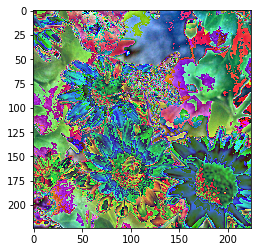

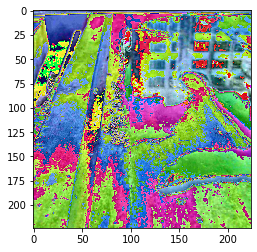

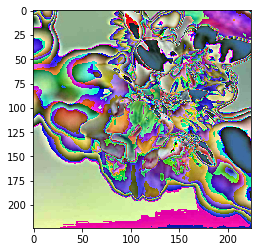

In [40]:
# 这些是normalize之后的图片的样子
imshow(img[31]) 
imshow(img[12]) 
imshow(img[5]) 

定义迁移学习模型
---------

In [41]:
# 查看一下resnet18的网络结构
model_resnet18 = models.resnet18(pretrained=True)
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
model_resnet18.fc.in_features # 最后一层全连接层的输入

512

In [43]:
# 把提取的参数不进行更新，设置requires_grad = False
def set_parameters_requires_grad(model,feature_extract):
    if feature_extract:
        for parm in model.parameters():
            parm.requires_grad = False #提取的参数梯度不更新
    

def initialize_model(model_name,num_classes,feature_extract,use_pretrained=True):
    if model_name == "resnet":
        #如果use_pretrained为True，从imagenet上返回预训练的模型和参数
        model_ft = models.resnet18(pretrained=use_pretrained)
        
        set_parameters_requires_grad(model_ft,feature_extract)
        
        # 最后的全连接层将返回两个类型，不在是1000个分类,而是我们的二分类问题
        num_ftrs = model_ft.fc.in_features
        #model_ft.fc是resnet的最后全连接层
        #(fc): Linear(in_features=512, out_features=1000, bias=True)
        #in_features 是全连接层的输入特征维度
        #print(num_ftrs)
        model_ft.fc = nn.Linear(num_ftrs,out_features=num_classes)
        input_size = 224 #resnet18网络输入图片维度是224，resnet34，50，101，152也是
    else:
        print("model not implemented")
        return None,None
    
    return model_ft,input_size

model_ft,input_size = initialize_model(model_name,
                                       num_classes,
                                       feature_extract)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
model_ft.layer1[0].conv1.weight.requires_grad

False

In [25]:
model_ft.fc.weight.requires_grad # 只有最后一层的requires_grad为true

True

# 定义模型训练方法
--------

In [53]:
# 定义模型训练方法
def train_model(model,dataloaders,loss_fn,optimizer,num_epochs=5):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict()) #深拷贝上面resnet模型参数
    best_acc = 0.
    for epoch in range(num_epochs):
        for phase in ["train","val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else: 
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase == "train"):
                    #torch.autograd.set_grad_enabled梯度管理器，可设置为打开或关闭
                    #phase=="train"是True和False，双等号要注意
                    outputs = model(inputs) # batch_size*2
                    loss = loss_fn(outputs,labels)
                   
                #返回每一行最大的数和索引，prds的位置是索引的位置
                #也可以preds = outputs.argmax(dim=1)
                _,preds = torch.max(outputs,1)
                
                # 如果是训练模式进行反向传播和梯度下降
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                # 交叉熵损失函数是平均过得，所以要乘上一个inputs.size(0)
                running_loss += loss.item()*inputs.size(0)
                # 正确率就是预测标签和真实labels标签一致的总个数
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
        
            # 计算出每个epoch的epoch_loss和epoch_acc
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
        
            print("{}Loss:{} Acc:{}".format(phase,epoch_loss,epoch_acc))
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                
                # 如果是在验证集上的正确率越好我们就靠谱模型的参数
                best_model_wts = copy.deepcopy(model)
                
            if phase == "val":
                val_acc_history.append(epoch_acc) # 记录下来每个epoch验证集的准确率
                
        print()
    
    time_elapsed = time.time() - since
    
    print("Training compete in {}m {}s".format(time_elapsed // 60),time_elapsed %60)
    print("Best val Acc: {}".format(best_acc))
    
     #把最新的参数复制到model中
    model.load_state_dict(best_model_wts)
    
    return  model,val_acc_history


训练模型
--------

In [47]:
# 把模型部署到对应的device上
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters() # 需要更新的参数
print("模型开始训练：Params to learn")
if feature_extract: # 此模式下只更新部分层的参数
    params_to_update = [] # 需要更新的采参数存放在这里
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True: # 找到需要更新的参数：即为最后一层的全连接层
            params_to_update.append(param)
            print("\t",name)
else: # 否侧，进行fine tuning，所有的参数都会更新
    for name,param in model_ft.named_parameters():
        if param.requires_grad ==True:
            print("\t",name)
# 定义优化器        
optimizer_ft = torch.optim.SGD(params_to_update,lr=0.001,momentum=0.9) # 定义优化器

# Setup the loss function
# 定义LossFunction
criterion = nn.CrossEntropyLoss() # 定义损失函数



模型开始训练：Params to learn
	 fc.weight
	 fc.bias


In [54]:
# 开始训练
model_ft,val_acc_history = train_model(model_ft,dataloaders_dict,
                                       loss_fn=criterion,
                                       optimizer=optimizer_ft,
                                       num_epochs=num_epochs)

trainLoss:0.7328234099950947 Acc:0.5573770491803278
valLoss:0.5772069895189572 Acc:0.7516339869281046

trainLoss:0.5512300583182789 Acc:0.7008196721311475
valLoss:0.42975109698725683 Acc:0.8169934640522876



KeyboardInterrupt: 

In [55]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  